**This notebook demonstrates Pansharpening using SURE and BP:**
- Data: Pleiades dataset contains 4 spectral bands which are assumed as ground truth ($\mathbf{x}$)
    - Simulated MSI ($\mathbf{y}$) is generated by apply the PSF filtering and downsampling to the ground truth, and adding Gaussian noise (SNR = 40 dB)
    - Simulated PAN ($\mathbf{G}$) is the average of all bands of the ground truth
- Loss function $$\mathcal{L}_{sure}=\|\mathbf{P}(\mathbf{y}-\mathbf{H}f_\theta(\mathbf{y})\|^2)+2\text{tr}\big[(\Omega_P)\mathbf{PH}\frac{\partial f_\theta(\mathbf{z})}{\partial\mathbf{u}}\big],$$
where $\mathbf{P}$ is a linear operator mapping LR image to its HR space, $\mathbf{z}$ is the network input (concatenating $\mathbf{u}=\mathbf{H^\dagger y}$ and $\mathbf{G}$) and $f_\theta(\cdot)$ is the network output.

In [1]:
# =============================================================================
# import lib
# =============================================================================
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.optim
import scipy.io as sio
from skimage.metrics import peak_signal_noise_ratio as psnr
from models.hs_models import *
from utils.hs_utils import *
from utils.common_utils import *
print(torch.cuda.get_device_name())

NVIDIA TITAN X (Pascal)


In [2]:
# =============================================================================
# load data
# =============================================================================
path_to_data = 'data/pleiades_pan.mat'
Xim = sio.loadmat(path_to_data)['I_GT'].astype(np.float32) # Ground truth
X=Xim[:256,:256,:]
scale = np.max(X)
X=X/scale
X_torch=torch.from_numpy(X).to(device,dtype=torch.float)
factor=4
[r,c,n_channels]=X.shape
x=hwc2chw(X_torch)
# ##########Simulate pan image
pan = torch.mean(X_torch,axis=-1)[None,:]
SNR=40.
[pan,sigmam]=add_noise(pan,SNR)
# ######### Simulate MS-LR by filtering, downsampling (factor = 4) and adding noise
psf=get_hs_psf(N=15, n_channels = n_channels, gaussian=True,sigma=2.)
MS_LR = Ax(x,psf,ratio=factor)
[MS,sigmah]=add_noise(MS_LR,SNR)
cond=1e-4
MSup = back_projx(MS,psf,factor,cond)
ref = X #np
# sigmah=sigmah.reshape(n_channels,1,1).to(device)

MS bands shape:  torch.Size([4, 64, 64])
Pan shape:  torch.Size([1, 256, 256])


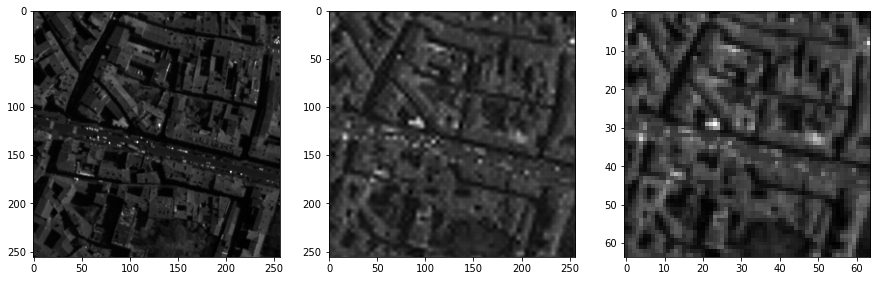

In [3]:
# =============================================================================
# show images
# =============================================================================
print('MS bands shape: ', MS.shape)
print('Pan shape: ', pan.shape)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(15,15))
ax1.imshow(pan[0,:,:].cpu(),cmap='gray')
ax2.imshow(MSup[1,:,:].cpu(),cmap='gray')
ax3.imshow(MS[1,:,:].cpu(),cmap='gray')
plt.show()

In [4]:
# =============================================================================
# Set parameters and net
# =============================================================================
show_every = 200 #500
num_iter = 3100
LR = 0.01 #try 0.01 0.001 0.0001

net=hs_net(ym_channel=1, yh_channel=n_channels, num_channels_down=64, 
           num_channels_up=64, num_channels_skip=16).to(device)

# net_inputs = [torch.randn(msi.shape).to(device),torch.randn(hsi_lr.shape).to(device)]
net_inputs = torch.cat((pan,MSup),dim=0)[None,:] #Noisy MSI and HSI
targets=[pan,MS]
optimizer = torch.optim.Adam(net.parameters(), lr=LR, eps=1e-3, amsgrad=True)

In [5]:
def pan_loss(model,inputs,targets,psf_hs, sigmah,sigmam,cond,loss_type='sure'):
    '''SURE and DIP losses'''
    yp = targets[0] #pan
    ym=targets[1] #ms = target
    sigmah_sq=sigmah**2
    sigmam_sq=sigmam**2
    ratio=4
    xhat=model(inputs) # size = [1, ms/pan_band+hsi_band, 200, 200]
    yhat=Ax(xhat.squeeze(),psf_hs,ratio) - ym
    pyhat = back_projx(yhat,psf_hs,ratio,cond)
    ####bpdip loss
    pan_out = torch.mean(xhat.squeeze(),dim=0)
    bp_loss = torch.sum((yp-pan_out)**2) + torch.sum(pyhat**2)
    #### Compute the trace (divergence) term by using Monte-Carlo SURE  
    epsilon = 1e-5
    b = torch.randn(inputs.shape).to(device,dtype=torch.float)
    outb = (model(inputs+epsilon*b)-xhat)/epsilon
    outb_p = torch.mean(outb.squeeze(),dim=0)*sigmam_sq
    Houtb = Ax(outb.squeeze(), psf_hs, ratio)
    tmp=invAAtx(Houtb,psf_hs,ratio,cond)*sigmah_sq
    outep = back_projx(tmp,psf_hs,ratio,cond)

    divm = 2 * torch.sum(b.squeeze()[1:,:,:] * outep) 
    divp= 2*torch.sum(b.squeeze()[:1,:,:]*outb_p) 
    sure_loss = bp_loss + divp + divm
    if loss_type=='bp':
        return bp_loss, xhat
    elif loss_type=='sure':
        return  sure_loss, xhat
    else:
        return  gdd_loss, xhat 

Starting optimization with ADAM
Iteration 00000  Loss = 34376.25391 PSNR = -3.730


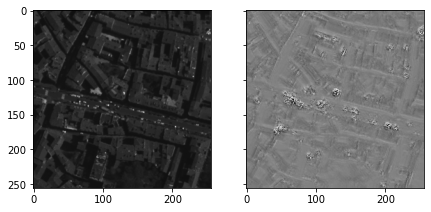

Iteration 00200  Loss = 133.38541 PSNR = 18.008


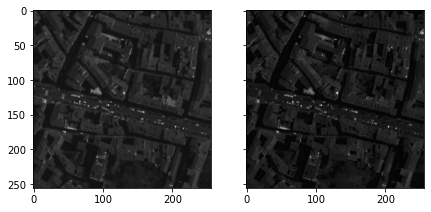

Iteration 00400  Loss = 100.08869 PSNR = 19.083


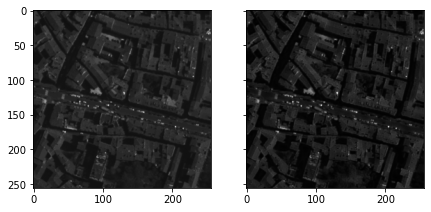

Iteration 00600  Loss = 40.14006 PSNR = 21.583


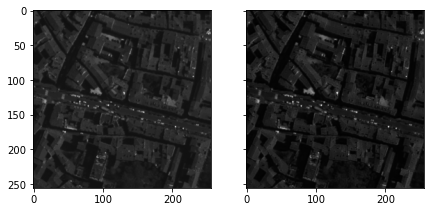

Iteration 00800  Loss = 29.22558 PSNR = 22.258


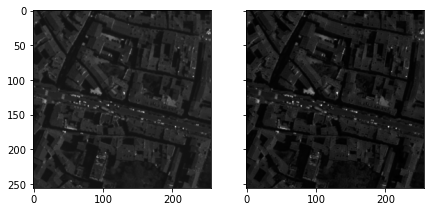

Iteration 01000  Loss = 24.87905 PSNR = 22.650


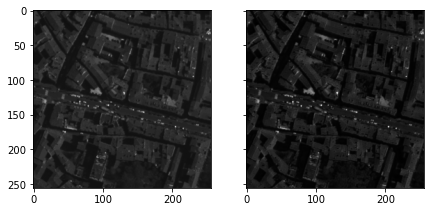

Iteration 01200  Loss = 20.22981 PSNR = 22.955


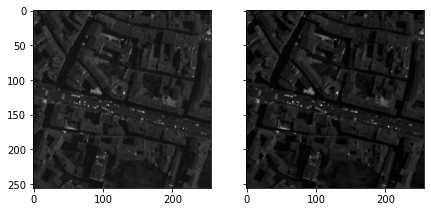

Iteration 01400  Loss = 19.96614 PSNR = 22.968


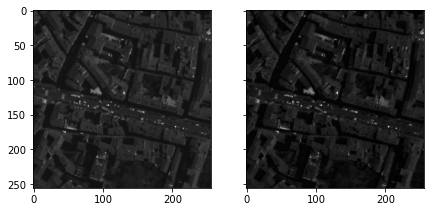

Iteration 01600  Loss = 17.08733 PSNR = 23.293


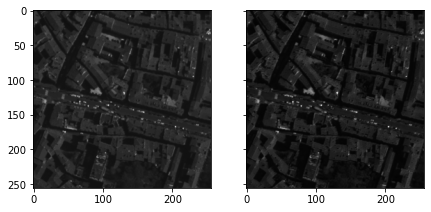

Iteration 01800  Loss = 15.75352 PSNR = 23.561


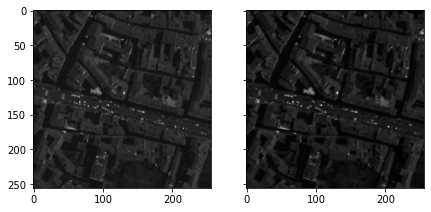

Iteration 02000  Loss = 15.91085 PSNR = 23.402


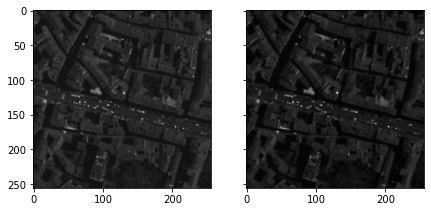

Iteration 02200  Loss = 12.95269 PSNR = 23.394


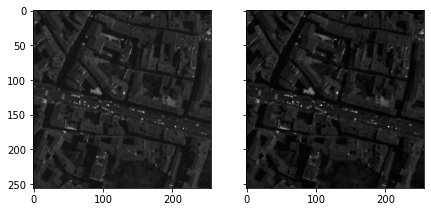

Iteration 02400  Loss = 12.96406 PSNR = 23.532


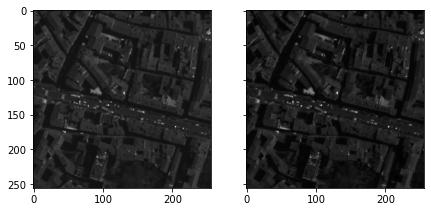

Iteration 02600  Loss = 12.90568 PSNR = 23.554


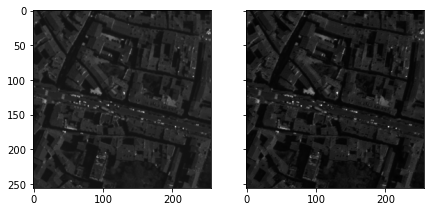

Iteration 02800  Loss = 11.79619 PSNR = 23.598


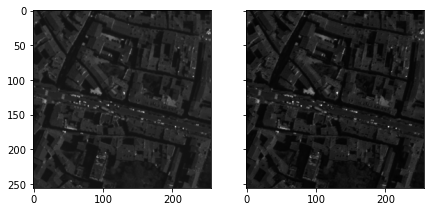

Iteration 03000  Loss = 11.28380 PSNR = 23.551


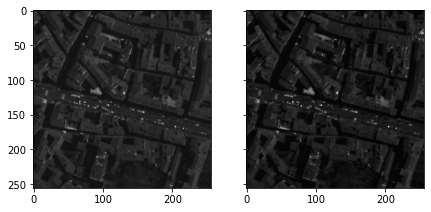

In [6]:
# =============================================================================
# Optimization
# =============================================================================
total_loss=[]
sre_history=[]
div_term = []
true_R=[]
print('Starting optimization with ADAM')
sre_init=0.
loss_type="sure"
out_avg=None
exp_weight=0.99
for it in range(num_iter):
    optimizer.zero_grad()
    loss, out_HR = pan_loss(net,net_inputs,targets,psf,sigmah,sigmam,cond,loss_type=loss_type)
    # Track the MSRE of reconstructed image
    out_np = chw2hwc(out_HR.detach().cpu().squeeze()).numpy()
    
#     if out_avg is None:
#         out_avg = out_np
#     else:
#         out_avg = out_avg * exp_weight + out_np * (1 - exp_weight)
#     if it==3000:
#         sio.savemat("dc_out"+loss_type+"30"+".mat",mdict={"img_"+loss_type:out_avg,"ref":ref,"sigmah":sigmah.cpu().numpy()})
    
    sre = SNRCal(ref,out_np)
    sre_history.append(sre)
    total_loss.append(loss.detach())
    loss.backward()
    optimizer.step()
    if it % show_every == 0:
        # loss - E_eps should be approx. to R
        print('Iteration %05d  Loss = %.5f PSNR = %.3f' % (it,loss.detach(),sre))
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7,7))
        ax1.imshow(ref[:,:,1],cmap='gray')
        ax2.imshow(out_np[:,:,1],cmap='gray')
        plt.show()

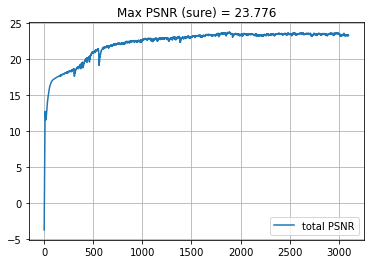

23.346084740206685


In [7]:
psnr_history=np.array(sre_history)
a=np.max(psnr_history)
plt.plot(psnr_history,label='total PSNR')

plt.title('Max PSNR (sure) = '+str(np.round(a,3)))
plt.legend()
plt.grid()
plt.show()
print(SNRCal(ref,out_np))